[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/combine-org/combine-notebooks/main?labpath=notebooks%2Fcellml.ipynb)
<a href="https://colab.research.google.com/github/combine-org/combine-notebooks/blob/main/notebooks/cellml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>

# Simple CellML example


This notebook creates a simple model in [CellML version 2](https://www.cellml.org/specifications/cellml_2.0/cellml_2_0_normative_specification.pdf) for illustration.  It is based on the libCellML tutorial series which can be found [here](https://libcellml.org/documentation/v0.4.0/user/tutorials/index).  The CellML we create here is a simple model for the growth in the number of cancer cells over time.  The libCellML library is used to build the model (including mathmatical formulations) and then simulate it.  The result of that simulation can be seen below.

<center>
<img src="./results/cellml_plot.png" alt="CellML Simulation Plot">
</center>

## 1) Including libraries and helper functions

Note: if the cell below is hidden, click on the dost to the left to view.

In [1]:
#note: metadata hides this cell on binder but it doesn't get hidden on colab
from pathlib import Path

#determine if we're running on colab
try:
  import google.colab
  exec_env = "colab"      #we seem to be on colab
  print("Assuming this notebook is running on Google Colab")
except:
  exec_env = "binder"     #assume it's binder

if exec_env == "colab":
  working_dir = f"{Path.cwd()}/combine-notebooks/notebooks/results"
  !git clone https://github.com/combine-org/combine-notebooks
  %cd combine-notebooks
  !pip install .
  %mkdir -p {working_dir}

else:
  #binder starts off in the notebook's folder
  working_dir = f"{Path.cwd()}/results"

import os
os.chdir(working_dir)

print("Results will be saved in %s"%working_dir)

Results will be saved in /Users/padraig/git/combine-notebooks/notebooks/results


In [2]:
from pathlib import Path

import importlib.util
from libcellml import Analyser, Component, Generator, GeneratorProfile, Model, Printer, Units, Validator, Variable
import matplotlib.pyplot as plt

from combine_notebooks.cellml_utilities import print_model, print_issues

In [3]:
def pretty_print(model : Model, old_model : Model = None):
    # Print the new model.
    printer = Printer()
    new_model_xml = printer.printModel(model)
    # Print the entire model in red.
    if old_model == None:
        print("\x1b[31m" + new_model_xml + "\x1b[0m") # ANSI escape used to print colours here.
    # If an old model is also given, highlight the lines that have changed.
    else:
        # Print the old model
        old_model_xml = printer.printModel(old_model)
        # Iterate over each new line
        old_model_xml_lines = old_model_xml.split('\n')
        for new_model_line in new_model_xml.split('\n'):
            # Print any new lines in red, otherwise print normally.
            if new_model_line in old_model_xml_lines:
                print(new_model_line)
            else:
                print("\x1b[31m" + new_model_line + "\x1b[0m") # ANSI escape used to print colours here.

## 2) Declaring the CellML model

We want to encode the following model in CellML:

$$\frac{dx}{dt} = C t$$
 
where $x$ is the total number of cancer cells, $t$ is time, and $C$ is some constant.

But, first, we need to create a `Model` object.

In [4]:
model = Model()

pretty_print(model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#"/>



All CellML elements must have a name, which is set using `setName()`. A CellML element can also have an id assigned to it using `setId()`. (An id is needed if you want to annotate a CellML element.)

In [5]:
old_model = model.clone()

model.setName("tutorial_model")
model.setId("tutorial_model_id")

pretty_print(model, old_model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id"/>



Next, we need to create some units so that we can specify the units of our variables. Units are used to ensure that equations are dimensionally consistent. For example, if we have a variable $x$ which is a length, and another variable $t$ which is a time, then we cannot add them together. However, if we multiply $t$ by a velocity, then we can add it to $x$.

CellML comes with some built-in units comprising of [SI base units](https://en.wikipedia.org/wiki/SI_base_unit) (e.g., `ampere`, `metre`, and `second`), [SI derived units](https://en.wikipedia.org/wiki/SI_derived_unit) (e.g., `coulomb`, `joule`, and `volt`), and some convenience units (`dimensionless`, `gram`, and `litre`). We can use these units to create new units, as well as create new base units.

For our model, we will create a new base unit `cell` for `x`, use the SI base unit `second` for $t$, and create a new derived unit `cell_per_second2` for $C$.

In [6]:
old_model = model.clone()

cell_unit = Units("cell")
model.addUnits(cell_unit)

cell_per_second2_unit = Units()
cell_per_second2_unit.setName("cell_per_second2")
cell_per_second2_unit.addUnit("cell")
cell_per_second2_unit.addUnit("second", -2)
model.addUnits(cell_per_second2_unit)

pretty_print(model, old_model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id">
  <units name="cell"/>
  <units name="cell_per_second2">
    <unit units="cell"/>
    <unit exponent="-2" units="second"/>
  </units>
</model>



Next, we create a wrapper component which purpose is to encapsulate (and therefore hide) other components. This makes it easier to reuse models since the connections between the encapsulated components will not need to be re-established. Note that the constructor for all named CellML elements is overloaded, so you can pass its name at the time of creation.

In [7]:
component = Component("cancer_cells_component")

This done, we need to add the component to the model. This sets it at the top-level of the components' encapsulation hierarchy. All other components need to be added to this component, rather than the model.

In [8]:
old_model = model.clone()

model.addComponent(component)

pretty_print(model, old_model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id">
  <units name="cell"/>
  <units name="cell_per_second2">
    <unit units="cell"/>
    <unit exponent="-2" units="second"/>
  </units>
  <component name="cancer_cells_component"/>
</model>



Now that we have a component, we can declare the variables that we need to compute our model.

In [9]:
old_model = model.clone()

x = Variable("x")
x.setUnits(cell_unit)
component.addVariable(x)

t = Variable("t")
t.setUnits("second")
component.addVariable(t)

C = Variable("C")
C.setUnits(cell_per_second2_unit)
component.addVariable(C)

pretty_print(model, old_model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id">
  <units name="cell"/>
  <units name="cell_per_second2">
    <unit units="cell"/>
    <unit exponent="-2" units="second"/>
  </units>
  <component name="cancer_cells_component">
    <variable name="x" units="cell"/>
    <variable name="t" units="second"/>
    <variable name="C" units="cell_per_second2"/>
  </component>
</model>



Equations are modelled using [MathML 2](https://www.w3.org/TR/MathML2/) strings.

In [10]:
# Create the MathML 2 string representing the governing equations.  
equation = \
  """
  <math xmlns="http://www.w3.org/1998/Math/MathML" xmlns:cellml="http://www.cellml.org/cellml/2.0#">
    <apply><eq/>
      <apply><diff/>
        <bvar><ci>t</ci></bvar>
        <ci>x</ci>
      </apply>
      <apply><times/>
        <ci>C</ci>
        <ci>t</ci>
      </apply>
    </apply>
  </math>
  """

Include the MathML 2 string in the component.

In [11]:
old_model = model.clone()

component.setMath(equation)

pretty_print(model, old_model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id">
  <units name="cell"/>
  <units name="cell_per_second2">
    <unit units="cell"/>
    <unit exponent="-2" units="second"/>
  </units>
  <component name="cancer_cells_component">
    <variable name="x" units="cell"/>
    <variable name="t" units="second"/>
    <variable name="C" units="cell_per_second2"/>
    <math xmlns="http://www.w3.org/1998/Math/MathML" xmlns:cellml="http://www.cellml.org/cellml/2.0#">
      <apply>
        <eq/>
        <apply>
          <diff/>
          <bvar>
            <ci>t</ci>
          </bvar>
          <ci>x</ci>
        </apply>
        <apply>
          <times/>
          <ci>C</ci>
          <ci>t</ci>
        </apply>
      </apply>
    </math>
  </component>
</model>



## 3) Write, print, and validate the generated model

Print the model to using the `print_model()` helper function and check that it is what we would expect.

In [12]:
print_model(model)

MODEL: 'tutorial_model', id: 'tutorial_model_id'
    UNITS: 2 custom units
        [0]: cell
        [1]: cell_per_second2
    COMPONENTS: 1 components
        [0]: 'cancer_cells_component'
            VARIABLES: 3 variables
                [0]: x [cell]
                [1]: t [second]
                [2]: C [cell_per_second2]


Create a validator and use it to check the model for issues.

In [13]:
validator = Validator()
validator.validateModel(model)
print_issues(validator)

Recorded 0 issues!



Save the model to a `.cellml` file and print the raw CellML text.

In [14]:
printer = Printer()
serialised_model = printer.printModel(model)
# Write the serialised string to a file.
f = Path(working_dir) / "tutorial_model.cellml"
write_file = open(f, "w")
write_file.write(serialised_model)
write_file.close()
print(serialised_model)


<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id">
  <units name="cell"/>
  <units name="cell_per_second2">
    <unit units="cell"/>
    <unit exponent="-2" units="second"/>
  </units>
  <component name="cancer_cells_component">
    <variable name="x" units="cell"/>
    <variable name="t" units="second"/>
    <variable name="C" units="cell_per_second2"/>
    <math xmlns="http://www.w3.org/1998/Math/MathML" xmlns:cellml="http://www.cellml.org/cellml/2.0#">
      <apply>
        <eq/>
        <apply>
          <diff/>
          <bvar>
            <ci>t</ci>
          </bvar>
          <ci>x</ci>
        </apply>
        <apply>
          <times/>
          <ci>C</ci>
          <ci>t</ci>
        </apply>
      </apply>
    </math>
  </component>
</model>



## 4) Simulate the model

Now, we simulate our model using libCellML and with $x_0=1 [cell]$ and $C=1 [\frac{cell}{second^2}]$. But, first, we need to check that our model is mathematically sound.

In [15]:
analyser = Analyser()
analyser.analyseModel(model)

x.setInitialValue(1)
C.setInitialValue(1)

analyser.analyseModel(model)
print_issues(analyser)

Recorded 0 issues!



Next, we generate some Python for our model. This code, saved in the `tutorial_model.py` file, can then be used to run our simulation.

In [16]:
generator = Generator()
generator.setModel(analyser.model())

profile = GeneratorProfile(GeneratorProfile.Profile.PYTHON)
generator.setProfile(profile)

implementation_code = generator.implementationCode()
f_py = f = Path(working_dir) / "tutorial_model.py"
with open(f, "w") as f:
    f.write(implementation_code)


Finally, we must load the Python file that we have just created, initalise the model, and then run the simulation. Running the simulation itself is done by iterating over 10 time steps and integrating the model at each time step. Outputs are then saved into some simple Python lists and plotted.

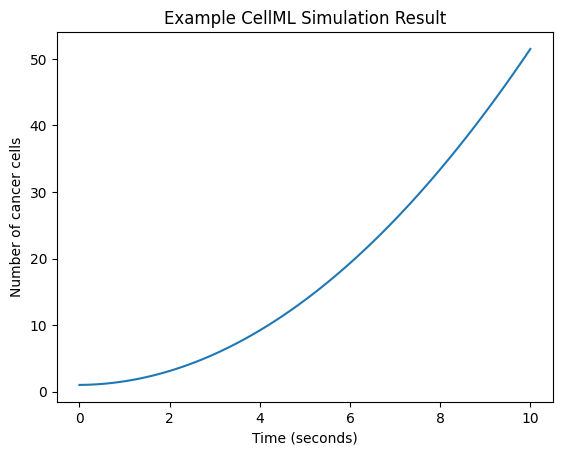

In [17]:
# Use the importlib functionality to open the generated code file.
spec = importlib.util.spec_from_file_location("tutorial_model", str(f_py))
model = importlib.util.module_from_spec(spec)

# Load the module.
spec.loader.exec_module(model)

# Create some arrays to hold the variables, states, and rates.
states = model.create_states_array()
rates = model.create_states_array()
variables = model.create_variables_array()

# A couple of arrays to hold the solution.
times = []
cancer_cells = []

# Initialise our model at t = 0.0 seconds. For the current model, only the call to initialise_variables() is needed.
# However, some models will also need compute_computed_constants(), compute_rates(), and compute_variables() to be
# called to be fully initialised. So, although they are not needed here, they are included for completeness.
t = 0.0
model.initialise_variables(states, variables)
# Note: a new version of libCellML is soon to be released, which will require the above line to be deleted and the below
# line to be uncommented.
# model.initialise_variables(states, rates, variables)
model.compute_computed_constants(variables)
model.compute_rates(t, states, rates, variables)
model.compute_variables(t, states, rates, variables)

# Keep track of the initial solution.
times.append(t)
cancer_cells.append(states[0])

# Create variables which control how the solution will run, representing the step size and the number of steps to take.
step_size = 0.1
step_count = 100

for step in range(1, step_count + 1):
    t = step * step_size

    # Compute the rates at this step.
    model.compute_rates(t, states, rates, variables)

    # Compute the states.
    for s in range(0, model.STATE_COUNT):
        states[s] = states[s] + rates[s] * step_size

    # Compute the variables that depend on the rates and states. For the current model, this is not needed, but some 
    # models may need it. So, although it is not needed here, it is included for completeness.
    model.compute_variables(t, states, rates, variables)

    # Keep track of the solution.
    times.append(t)
    cancer_cells.append(states[0])
plt.title('Example CellML Simulation Result')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of cancer cells')
plt.plot(times, cancer_cells)
plt.savefig(str(working_dir) + '/cellml_plot.png')


At this stage, you might want to modify the model to also compute the analatycal solution, i.e.

$$x(t) = x_0 + \frac{C t^2}{2}$$

where $x_0$ is the initial number of cancer cells.

From there, you should find out that the two solutions are very close. (To get a more accurate solution for the ordinary differential equation, use a smaller time step.)